<a href="https://colab.research.google.com/github/sanzidarahman1/ENGG_680_Project/blob/main/LSTM_EB_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

# Load the data
train_val_file_path = 'train and validation_EB(1).xlsx'
test_file_path = 'test_EB.xlsx'

train_val_data = pd.read_excel(train_val_file_path)
test_data = pd.read_excel(test_file_path)

# Combine datasets for preprocessing consistency
data = pd.concat([train_val_data, test_data]).sort_values(by=['date', 'time']).reset_index(drop=True)

# Convert date and time columns
data['date'] = pd.to_datetime(data['date'])
data['time'] = pd.to_datetime(data['time'], format='%H:%M:%S').dt.hour  # Use hour as a feature

# Encode categorical variables
data['weekend/holiday (y/n)'] = data['weekend/holiday (y/n)'].map({'y': 1, 'n': 0})
data['stampede (y/n)'] = data['stampede (y/n)'].map({'y': 1, 'n': 0})
data = pd.get_dummies(data, columns=['Day_Type'], prefix='DayType')

# Add lagged weather features
data['temp_lag'] = data['temp. (C)'].shift(1).fillna(0)
data['precip_lag'] = data['daily precip. (mm)'].shift(1).fillna(0)
data['wind_lag'] = data['wind (km/h)'].shift(1).fillna(0)

# Normalize numeric features
scaler = MinMaxScaler()
features = ['vehicle count', 'temp. (C)', 'daily precip. (mm)', 'wind (km/h)', 'temp_lag', 'precip_lag',
            'wind_lag', 'weekend/holiday (y/n)', 'stampede (y/n)', 'time'] + \
           [col for col in data.columns if 'DayType_' in col]
data[features] = scaler.fit_transform(data[features])

# Separate training/validation and test datasets
train_val_data = data.iloc[:-len(test_data)]  # First 10 months
test_data = data.iloc[-len(test_data):]       # Last 2 months


In [ ]:
# Function to create sequences
def create_sequences(data, sequence_length, target_col):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data.iloc[i-sequence_length:i].values)
        y.append(data.iloc[i, target_col])
    return np.array(X), np.array(y)

# Define the target column index
target_col_idx = data.columns.get_loc('vehicle count')

# Generate sequences
sequence_length = 24
X_train_val, y_train_val = create_sequences(train_val_data[features], sequence_length, target_col_idx)
X_test, y_test = create_sequences(test_data[features], sequence_length, target_col_idx)

# Split into training and validation (80% training, 20% validation)
split_idx = int(0.8 * len(X_train_val))
X_train, X_val = X_train_val[:split_idx], X_train_val[split_idx:]
y_train, y_val = y_train_val[:split_idx], y_train_val[split_idx:]


In [ ]:
# Build the LSTM model
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model with EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping]
)


Epoch 1/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 24s 29ms/step - loss: 0.0029 - mae: 0.0319 - val_loss: 5.5775e-04 - val_mae: 0.0104
Epoch 2/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 42s 30ms/step - loss: 8.1535e-04 - mae: 0.0138 - val_loss: 5.2702e-04 - val_mae: 0.0091
Epoch 3/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 40s 29ms/step - loss: 8.0050e-04 - mae: 0.0122 - val_loss: 4.1242e-04 - val_mae: 0.0087
Epoch 4/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 40s 28ms/step - loss: 5.8212e-04 - mae: 0.0104 - val_loss: 7.5943e-04 - val_mae: 0.0124
Epoch 5/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - loss: 6.1390e-04 - mae: 0.0101 - val_loss: 2.9796e-04 - val_mae: 0.0052
Epoch 6/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - loss: 6.7638e-04 - mae: 0.0100 - val_loss: 2.7537e-04 - val_mae: 0.0051
Epoch 7/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - loss: 8.4879e-04 - mae: 0.0105 - val_loss: 2.4340e-04 - val_mae: 0.0032
Epoch 8/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 41s 28ms/step - loss: 4.2741e-04 - mae: 0.0080 - val_loss: 2.6337e-0

In [ ]:
# Evaluate the model
train_predictions = model.predict(X_train)
val_predictions = model.predict(X_val)
# Predictions
test_predictions = model.predict(X_test)

# Reverse scaling for predictions and true values
def reverse_scaling(predictions, true_values):
    predictions_actual = scaler.inverse_transform(
        np.hstack((predictions, np.zeros((predictions.shape[0], len(features) - 1))))
    )[:, 0]
    true_values_actual = scaler.inverse_transform(
        np.hstack((true_values.reshape(-1, 1), np.zeros((true_values.shape[0], len(features) - 1))))
    )[:, 0]
    return predictions_actual, true_values_actual

train_pred_actual, y_train_actual = reverse_scaling(train_predictions, y_train)
val_pred_actual, y_val_actual = reverse_scaling(val_predictions, y_val)
test_pred_actual, y_test_actual = reverse_scaling(test_predictions, y_test)
y_pred_actual, y_test_actual = reverse_scaling(test_predictions, y_test)

# Function to calculate metrics
def calculate_metrics(true_values, predictions):
    mae = mean_absolute_error(true_values, predictions)
    mse = mean_squared_error(true_values, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(true_values, predictions)
    return mae, mse, rmse, r2

# Calculate metrics
train_metrics = calculate_metrics(y_train_actual, train_pred_actual)
val_metrics = calculate_metrics(y_val_actual, val_pred_actual)
test_metrics = calculate_metrics(y_test_actual, test_pred_actual)

# Display metrics
metrics_df = pd.DataFrame({
    'Data': ['Training', 'Validation', 'Testing'],
    'MAE': [train_metrics[0], val_metrics[0], test_metrics[0]],
    'MSE': [train_metrics[1], val_metrics[1], test_metrics[1]],
    'RMSE': [train_metrics[2], val_metrics[2], test_metrics[2]],
    'R²': [train_metrics[3], val_metrics[3], test_metrics[3]],
})

print(metrics_df)

# Save metrics to a CSV
metrics_df.to_csv('model_metrics.csv', index=False)
print("\nMetrics saved to 'model_metrics.csv'")


732/732 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
         Data       MAE          MSE       RMSE        R²
0    Training  2.984775   300.584256  17.337366  0.980396
1  Validation  3.276044   307.303241  17.530067  0.985234
2     Testing  8.258342  1308.146309  36.168305  0.981980

Metrics saved to 'model_metrics.csv'


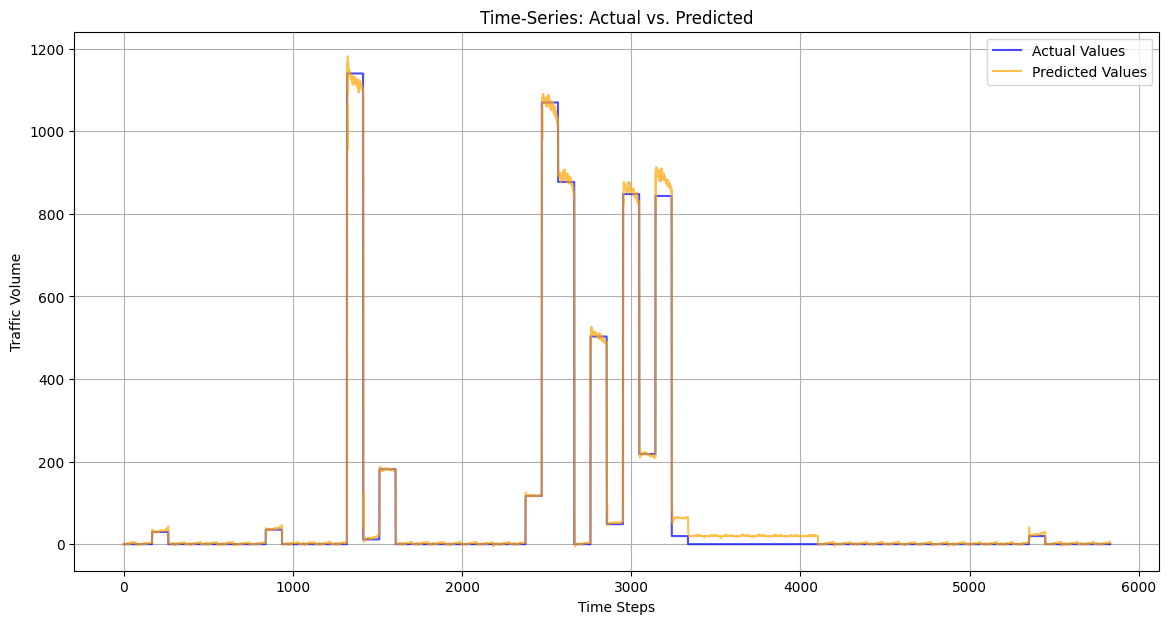

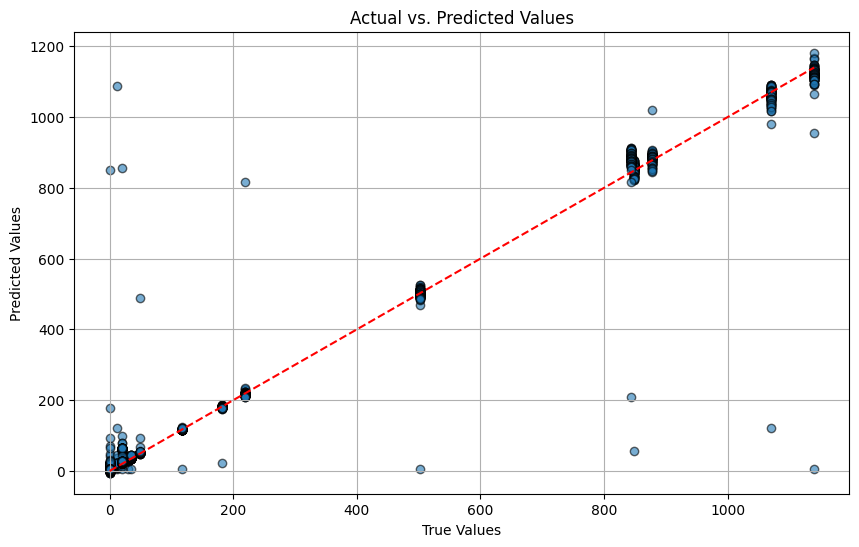

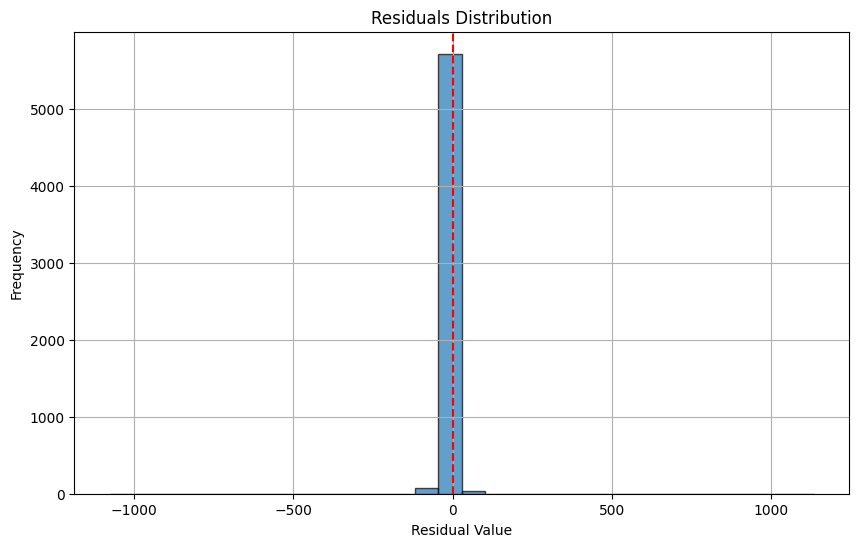

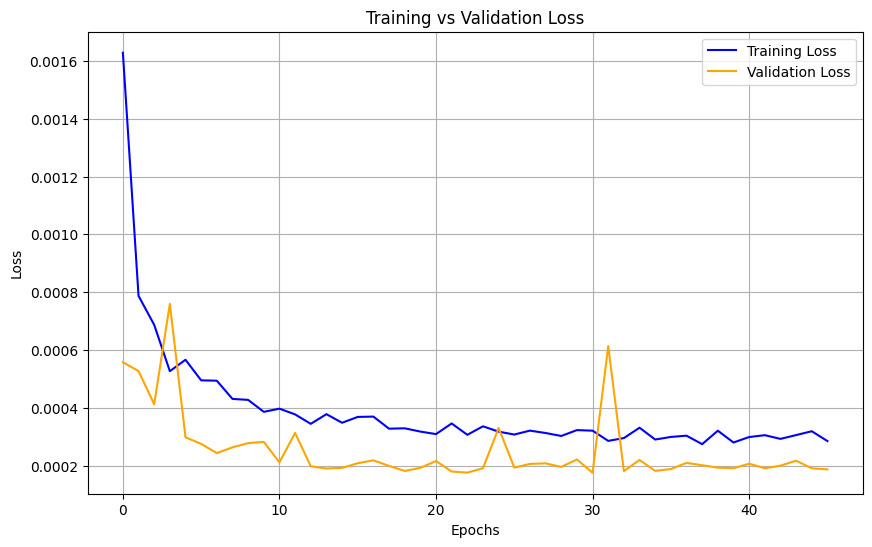

In [ ]:
# Time-series visualization
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, label="Actual Values", color='blue', alpha=0.7)
plt.plot(y_pred_actual, label="Predicted Values", color='orange', alpha=0.7)
plt.title("Time-Series: Actual vs. Predicted")
plt.xlabel("Time Steps")
plt.ylabel("Traffic Volume")
plt.legend()
plt.grid(True)
plt.show()

# Scatter plot: Actual vs. Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test_actual, y_pred_actual, alpha=0.6, edgecolors='k')
plt.plot([min(y_test_actual), max(y_test_actual)], [min(y_test_actual), max(y_test_actual)], 'r', linestyle='--')
plt.title("Actual vs. Predicted Values")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.grid(True)
plt.show()

# Residuals histogram
residuals = y_test_actual - y_pred_actual
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, alpha=0.7, edgecolor='black')
plt.title("Residuals Distribution")
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.axvline(0, color='r', linestyle='--')
plt.grid(True)
plt.show()

# Training vs. Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()
